In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("/media/hdd/github/sprintdl/")

from sprintdl.main import *
import sprintdl

device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

from sprintdl.models.efficientnet import *

# Define required

In [2]:
import pandas as pd

In [3]:
fpath = Path("/media/hdd/Datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_Metadata.csv")

In [4]:
df = pd.read_csv(fpath); df.head(100)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
95,95,IM-0261-0001.jpeg,Normal,TRAIN,NaN,NaN
96,96,IM-0257-0001.jpeg,Normal,TRAIN,NaN,NaN
97,97,IM-0256-0001.jpeg,Normal,TRAIN,NaN,NaN
98,98,IM-0255-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
df.shape

(5910, 6)

In [6]:
df = df[df["Dataset_type"]=='TRAIN']

In [7]:
df.to_csv("/media/hdd/Datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train.csv")

In [8]:
len(df.Label.unique())

2

In [9]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 256

In [10]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
       partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
lr = .001
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [11]:
tl = TableLoader("/media/hdd/Datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train.csv", "X_ray_image_name", "Label", add_before="/media/hdd/Datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/")

In [12]:
il = ImageList(tl, tfms = tfms)

In [13]:
sd = SplitData.split_by_func(il, partial(random_splitter,p_valid = .2))

In [14]:
ll = label_by_func(sd, partial(table_labeler, dic = tl), proc_y=CategoryProcessor())

In [15]:
data = ll.to_databunch(bs, c_in=3, c_out=2)

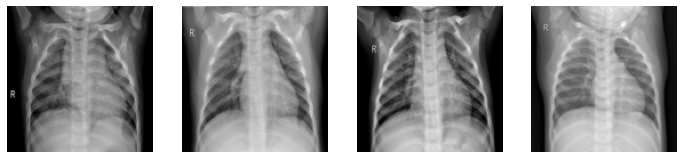

In [16]:
show_batch(data)

# Xresnet34 + pruning

In [17]:
arch = partial(xresnet34, c_out =2)()

In [18]:
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs+[PruningCallback], opt_func=opt_func)

In [19]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.420835,0.855425,0.895043,0.754302,00:19


Pruning: 38


In [20]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.308520,0.938443,0.642348,0.750478,00:20
1,0.284349,0.955660,0.271855,0.965583,00:21


Pruning: 38
Pruning: 38


In [21]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.266132,0.967689,0.336473,0.923518,00:21
1,0.273807,0.963915,0.282272,0.956023,00:21


Pruning: 38
Pruning: 38


# Xresnet34

In [97]:
arch = partial(xresnet34, c_out =2)()

In [98]:
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [99]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.419297,0.868346,0.465628,0.802412,00:21


In [100]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.305885,0.940114,0.781749,0.793135,00:20
1,0.293040,0.949382,0.284143,0.954545,00:21


In [101]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.273146,0.963165,0.302002,0.931354,00:20
1,0.272076,0.963641,0.340235,0.925789,00:21


# Effnet

In [15]:
from sprintdl.models.efficientnet import *

In [16]:
arch = efficientnet(2, pretrained=False)

In [17]:
clear_memory()

In [18]:
# learn.destroy()

In [19]:
data = ll.to_databunch(64, c_in=3, c_out=2)

In [20]:
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs+[PruningCallback], opt_func=opt_func)

In [21]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.509987,0.838022,0.689972,0.729412,00:23


In [22]:
learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.346213,0.920534,0.777552,0.729412,00:23
1,0.382069,0.912330,2058325.207843,0.729412,00:23
2,0.368579,0.906704,8114.189706,0.729412,00:24
3,0.276484,0.958978,39.437776,0.729412,00:23


In [23]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.301258,0.947961,49.023744,0.714706,00:23
1,0.289093,0.952180,0.379353,0.942157,00:24


In [24]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.273676,0.962494,1.504329,0.495098,00:23
1,0.269934,0.962025,0.351727,0.922549,00:23


# Effnet + Pruning

In [17]:
from sprintdl.models.efficientnet import *

In [18]:
arch = efficientnet(2, pretrained=False)

In [19]:
clear_memory()

In [20]:
# learn.destroy()

In [21]:
data = ll.to_databunch(64, c_in=3, c_out=2)

In [22]:
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [23]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.489117,0.849292,0.659654,0.742830,00:24


In [24]:
learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.322619,0.939151,0.708251,0.742830,00:23
1,0.477249,0.878302,95549.078394,0.742830,00:24
2,0.570672,0.764151,72.185237,0.742830,00:24
3,0.389461,0.891745,1.044979,0.748566,00:24


In [25]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.351468,0.923113,0.551965,0.823136,00:24
1,0.342704,0.925708,0.375326,0.907266,00:24


In [26]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.317474,0.939858,0.360716,0.904398,00:24
1,0.305561,0.941038,0.294351,0.945507,00:24


In [27]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.282086,0.958255,0.637681,0.869025,00:24
1,0.301136,0.943868,0.720867,0.937859,00:24
